# Identity Document Classification using Custom CNN

This notebook walks through the process of training a custom CNN model to classify identity documents by country of origin.

Our dataset consists of segmented images of identity documents from 10 different countries, extracted using a YOLO instance segmentation model.

## 1. Setup and Imports

In [3]:
import os
import sys
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import cv2

# Add current directory to path to import local modules
sys.path.append('.')

# Import custom modules
from dataset import load_data, get_transforms
from models import CustomCNNModel
from train import train_model, evaluate_model, visualize_training_history, model_summary, visualize_misclassified_samples

# Set the random seed for reproducibility
SEED = 43
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

c:\Users\zerad\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU
CUDA Version: 12.1
Memory: 8.59 GB


## 2. Configuration

Let's set up the configuration parameters for our training. These parameters align with the arguments in `run_training.py`.

In [4]:
# Data parameters
DATA_DIR = '../../data/cropped_images'  # Path to dataset directory
IMG_SIZE = 224  # Input image size
VAL_SPLIT = 0.15  # Percentage of data to use for validation
TEST_SPLIT = 0.15  # Percentage of data to use for testing
BATCH_SIZE = 64  # Batch size for training - adjust based on your GPU memory
NUM_WORKERS = 4  # Number of workers for data loading

# Training parameters
EPOCHS = 150  # Maximum number of epochs to train for
LEARNING_RATE = 0.001  # Initial learning rate
WEIGHT_DECAY = 1e-4  # L2 regularization
PATIENCE = 7  # Number of epochs to wait for early stopping
CHECKPOINT_DIR = Path('../../checkpoints/custom_cnn')  # Directory to save model checkpoints
os.makedirs(CHECKPOINT_DIR, exist_ok=True)  # Create checkpoint directory if it doesn't exist

## 3. Data Loading and Exploration

Now let's load our data and explore it to understand what we're working with.

In [5]:
# Load the data
data = load_data(
    data_dir=DATA_DIR,
    img_size=IMG_SIZE,
    val_split=VAL_SPLIT,
    test_split=TEST_SPLIT,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    seed=SEED
)

# Get class names
class_names = data['class_names']
num_classes = data['num_classes']

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Dataset split: 700 training, 150 validation, 150 test
alb_id: 70 train, 15 val, 15 test
aze_passport: 70 train, 15 val, 15 test
esp_id: 70 train, 15 val, 15 test
est_id: 70 train, 15 val, 15 test
fin_id: 70 train, 15 val, 15 test
grc_passport: 70 train, 15 val, 15 test
lva_passport: 70 train, 15 val, 15 test
rus_internalpassport: 70 train, 15 val, 15 test
srb_passport: 70 train, 15 val, 15 test
svk_id: 70 train, 15 val, 15 test
Number of classes: 10
Class names: ['alb_id', 'aze_passport', 'esp_id', 'est_id', 'fin_id', 'grc_passport', 'lva_passport', 'rus_internalpassport', 'srb_passport', 'svk_id']


c:\Users\zerad\Desktop\Sujan\PassportPAL\notebooks\classifierlear\dataset.py:76: UserWarning: Argument(s) 'mean, std' are not valid for transform GaussNoise
  A.GaussNoise(mean=0, std=(0.01, 0.05), p=0.3),  # Add noise


## 4. Dataset Visualization

Let's visualize some samples from our dataset. The user mentioned an issue where the samples displayed might already be augmented. Let's fix this by creating a visualization function that directly loads the images from disk without applying transformations.

Original training samples:


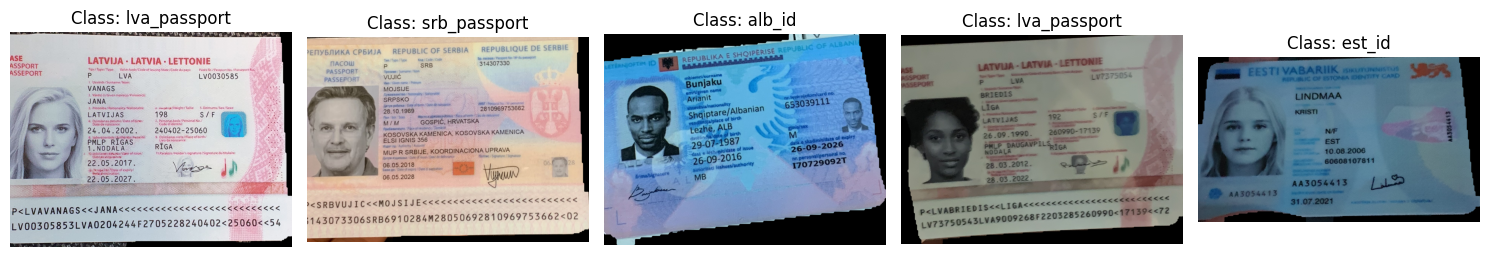

In [6]:
def visualize_original_samples(dataset, class_names, num_images=5, figsize=(15, 10)):
    """
    Visualize original samples from a dataset without any transformations.
    
    Args:
        dataset: PyTorch dataset object
        class_names (list): List of class names
        num_images (int): Number of images to display
        figsize (tuple): Figure size
    """
    # Select random indices
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    # Create figure
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    
    for i, idx in enumerate(indices):
        # Get image path and label directly from dataset
        img_path = dataset.image_paths[idx]
        label = dataset.labels[idx]
        
        # Load original image without transformations
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Display image
        axes[i].imshow(image)
        axes[i].set_title(f"Class: {class_names[label]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize original samples
print("Original training samples:")
visualize_original_samples(data['train_dataset'], class_names)

## 5. Augmentation Visualization

Now let's visualize what our augmentation pipeline does to the images. This will help us understand how our data is transformed during training.

Augmentation examples:


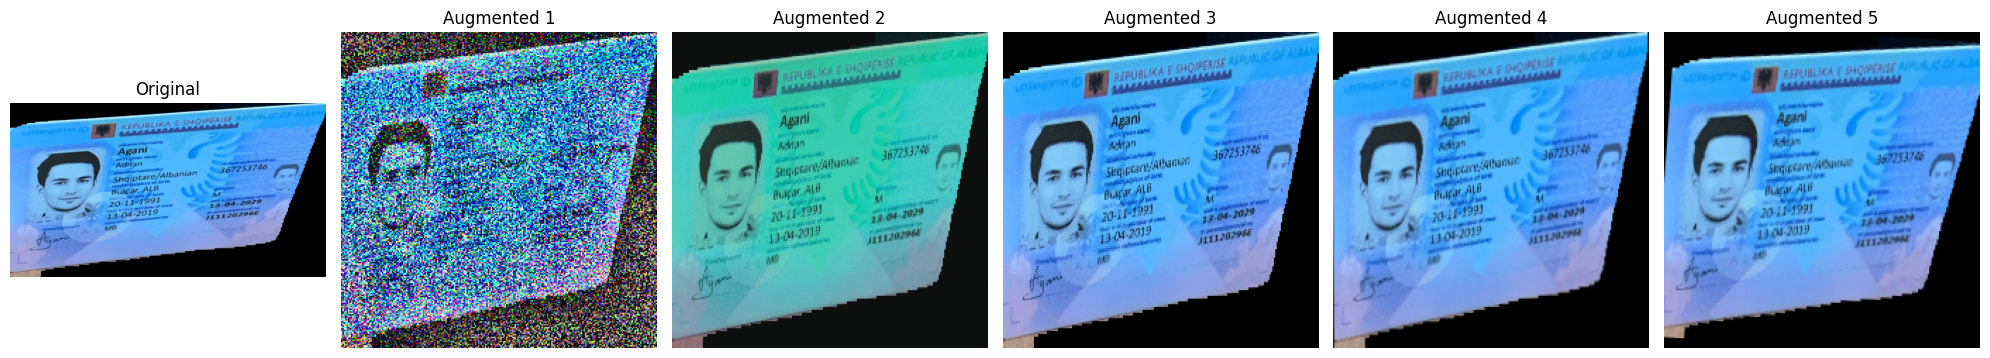

In [7]:
def visualize_augmentation_pipeline(image_path, transform, num_samples=5, figsize=(20, 10)):
    """
    Visualize how augmentation affects a single image.
    
    Args:
        image_path (str): Path to the image
        transform: Transformation pipeline
        num_samples (int): Number of augmented samples to generate
        figsize (tuple): Figure size
    """
    # Load original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Create figure
    fig, axes = plt.subplots(1, num_samples + 1, figsize=figsize)
    
    # Display original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # Generate and display augmented images
    for i in range(num_samples):
        # Apply transformations (excluding normalization and ToTensorV2 for visualization)
        augmented = transform(image=original_image.copy())
        augmented_image = augmented['image']
        
        if torch.is_tensor(augmented_image):
            # Convert tensor back to numpy for visualization
            augmented_image = augmented_image.permute(1, 2, 0).numpy()
            # Denormalize if needed
            augmented_image = augmented_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            augmented_image = np.clip(augmented_image, 0, 1)
        
        # Display augmented image
        axes[i+1].imshow(augmented_image)
        axes[i+1].set_title(f"Augmented {i+1}")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Get a sample image path from the first class
sample_class_dir = os.path.join(DATA_DIR, class_names[0])
sample_image_path = os.path.join(sample_class_dir, os.listdir(sample_class_dir)[0])

# Get the transformation pipeline (training transforms with augmentation)
transforms_dict = get_transforms(img_size=IMG_SIZE, use_augmentation=True)
train_transform = transforms_dict['train']

# Visualize augmentation pipeline
print("Augmentation examples:")
visualize_augmentation_pipeline(sample_image_path, train_transform)

## 6. Model Architecture

Now let's create our custom CNN model and examine its architecture.

In [8]:
# Create the model
model = CustomCNNModel(num_classes=num_classes)
model.to(device)

# Print model summary
model_summary(model)

# Define loss function, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

CustomCNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc_bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_bn2): 

In [9]:
import wandb

# Initialize wandb
wandb.init(project="PassportPAL-Classifier", name="Custom_CNN", config={
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "architecture": "Custom_CNN",
})

# Log model architecture
wandb.watch(model, log="all")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: wisewizer to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 7. Training the Model

Now we'll train our custom CNN model on the dataset. The training function handles both training and validation, and includes early stopping to prevent overfitting.

In [10]:
# Generate a unique model name with timestamp
from datetime import datetime
model_name = f"custom_cnn_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# Train the model
model, history = train_model(
    model=model,
    dataloaders={
        'train': data['train_loader'],
        'val': data['val_loader']
    },
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=EPOCHS,
    device=device,
    save_dir=CHECKPOINT_DIR,
    model_name=model_name,
    early_stopping_patience=PATIENCE
)

Epoch 1/150
----------


train: 100%|██████████| 22/22 [00:25<00:00,  1.16s/it]


train Loss: 2.0619 Acc: 0.2729


val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


val Loss: 1.5561 Acc: 0.4667

Epoch 2/150
----------


train: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it]


train Loss: 1.4863 Acc: 0.4914


val: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


val Loss: 1.0544 Acc: 0.6600

Epoch 3/150
----------


train: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it]


train Loss: 1.1272 Acc: 0.6557


val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


val Loss: 0.7553 Acc: 0.8600

Epoch 4/150
----------


train: 100%|██████████| 22/22 [00:25<00:00,  1.15s/it]


train Loss: 0.8073 Acc: 0.7800


val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


val Loss: 0.4583 Acc: 0.8933

Epoch 5/150
----------


train: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it]


train Loss: 0.6634 Acc: 0.8243


val: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


val Loss: 0.3700 Acc: 0.9133

Epoch 6/150
----------


train: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it]


train Loss: 0.5354 Acc: 0.8600


val: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


val Loss: 0.3512 Acc: 0.9067

Epoch 7/150
----------


train: 100%|██████████| 22/22 [00:25<00:00,  1.17s/it]


train Loss: 0.4809 Acc: 0.8657


val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


val Loss: 0.2783 Acc: 0.9267

Epoch 8/150
----------


train: 100%|██████████| 22/22 [00:28<00:00,  1.29s/it]


train Loss: 0.3989 Acc: 0.8871


val: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


val Loss: 0.2339 Acc: 0.9400

Epoch 9/150
----------


train: 100%|██████████| 22/22 [00:26<00:00,  1.21s/it]


train Loss: 0.3418 Acc: 0.9014


val: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


val Loss: 0.1786 Acc: 0.9600

Epoch 10/150
----------


train: 100%|██████████| 22/22 [00:25<00:00,  1.18s/it]


train Loss: 0.3599 Acc: 0.8971


val: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


val Loss: 0.1571 Acc: 0.9600

Epoch 11/150
----------


train: 100%|██████████| 22/22 [00:26<00:00,  1.20s/it]


train Loss: 0.3177 Acc: 0.9200


val: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


val Loss: 0.1662 Acc: 0.9600

Epoch 12/150
----------


train: 100%|██████████| 22/22 [00:25<00:00,  1.16s/it]


train Loss: 0.2955 Acc: 0.9129


val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


val Loss: 0.2246 Acc: 0.9200

Epoch 13/150
----------


train: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it]


train Loss: 0.2632 Acc: 0.9300


val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


val Loss: 0.1165 Acc: 0.9600

Epoch 14/150
----------


train: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it]


train Loss: 0.2236 Acc: 0.9429


val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


val Loss: 0.1368 Acc: 0.9467

Epoch 15/150
----------


train: 100%|██████████| 22/22 [00:25<00:00,  1.15s/it]


train Loss: 0.2172 Acc: 0.9371


val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


val Loss: 0.0920 Acc: 0.9800

Epoch 16/150
----------


train: 100%|██████████| 22/22 [00:26<00:00,  1.19s/it]


train Loss: 0.1735 Acc: 0.9557


val: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


val Loss: 0.1079 Acc: 0.9733

Epoch 17/150
----------


train: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it]


train Loss: 0.1969 Acc: 0.9471


val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


val Loss: 0.0991 Acc: 0.9667

Epoch 18/150
----------


train: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it]


train Loss: 0.1583 Acc: 0.9500


val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


val Loss: 0.1368 Acc: 0.9533

Epoch 19/150
----------


train: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it]


train Loss: 0.1722 Acc: 0.9386


val: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


val Loss: 0.1212 Acc: 0.9533

Epoch 20/150
----------


train: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it]


train Loss: 0.1200 Acc: 0.9686


val: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


val Loss: 0.0864 Acc: 0.9800

Epoch 21/150
----------


train: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it]


train Loss: 0.1374 Acc: 0.9529


val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


val Loss: 0.1105 Acc: 0.9733

Epoch 22/150
----------


train: 100%|██████████| 22/22 [00:25<00:00,  1.15s/it]


train Loss: 0.1436 Acc: 0.9600


val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


val Loss: 0.1009 Acc: 0.9600
Early stopping triggered after 22 epochs
Training complete in 12m 3s
Best val Acc: 0.9800 at epoch 15


## 8. Visualizing Training Results

Let's visualize our training history to see how the model performed over time.

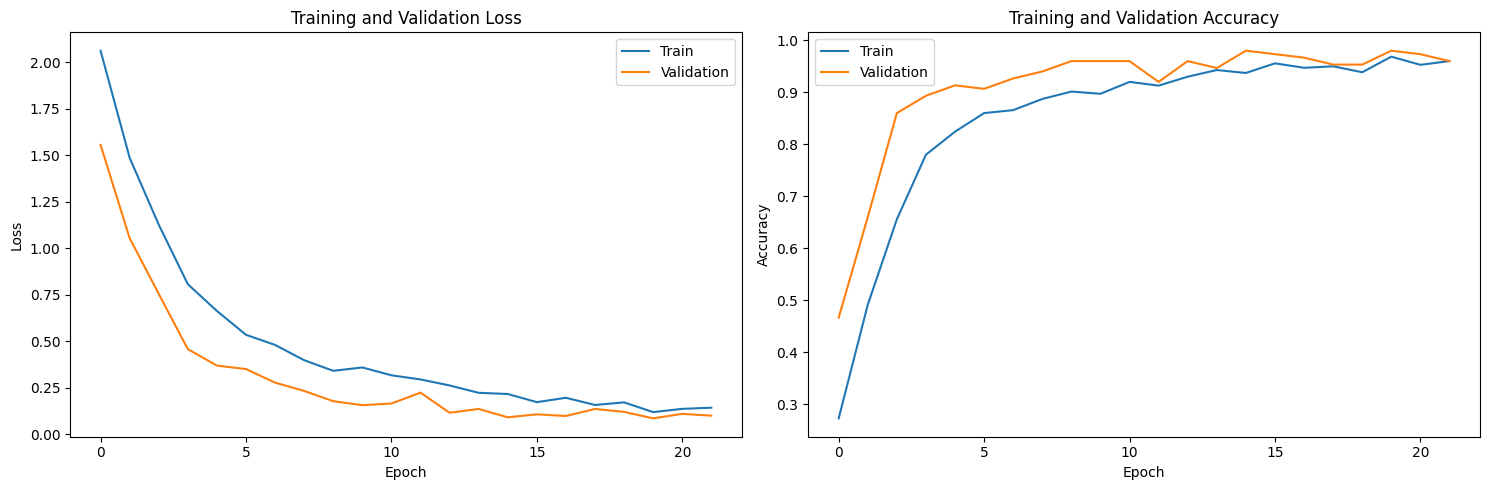

In [11]:
# Visualize training history
visualize_training_history(history)

## 9. Model Evaluation

Now let's evaluate our trained model on the test set to see how well it generalizes to unseen data.

Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:
                      precision    recall  f1-score   support

              alb_id       1.00      1.00      1.00        15
        aze_passport       1.00      1.00      1.00        15
              esp_id       1.00      1.00      1.00        15
              est_id       1.00      1.00      1.00        15
              fin_id       1.00      1.00      1.00        15
        grc_passport       1.00      1.00      1.00        15
        lva_passport       1.00      1.00      1.00        15
rus_internalpassport       1.00      1.00      1.00        15
        srb_passport       1.00      1.00      1.00        15
              svk_id       1.00      1.00      1.00        15

            accuracy                           1.00       150
           macro avg       1.00      1.00      1.00       150
        weighted avg       1.00      1.00      1.00       150



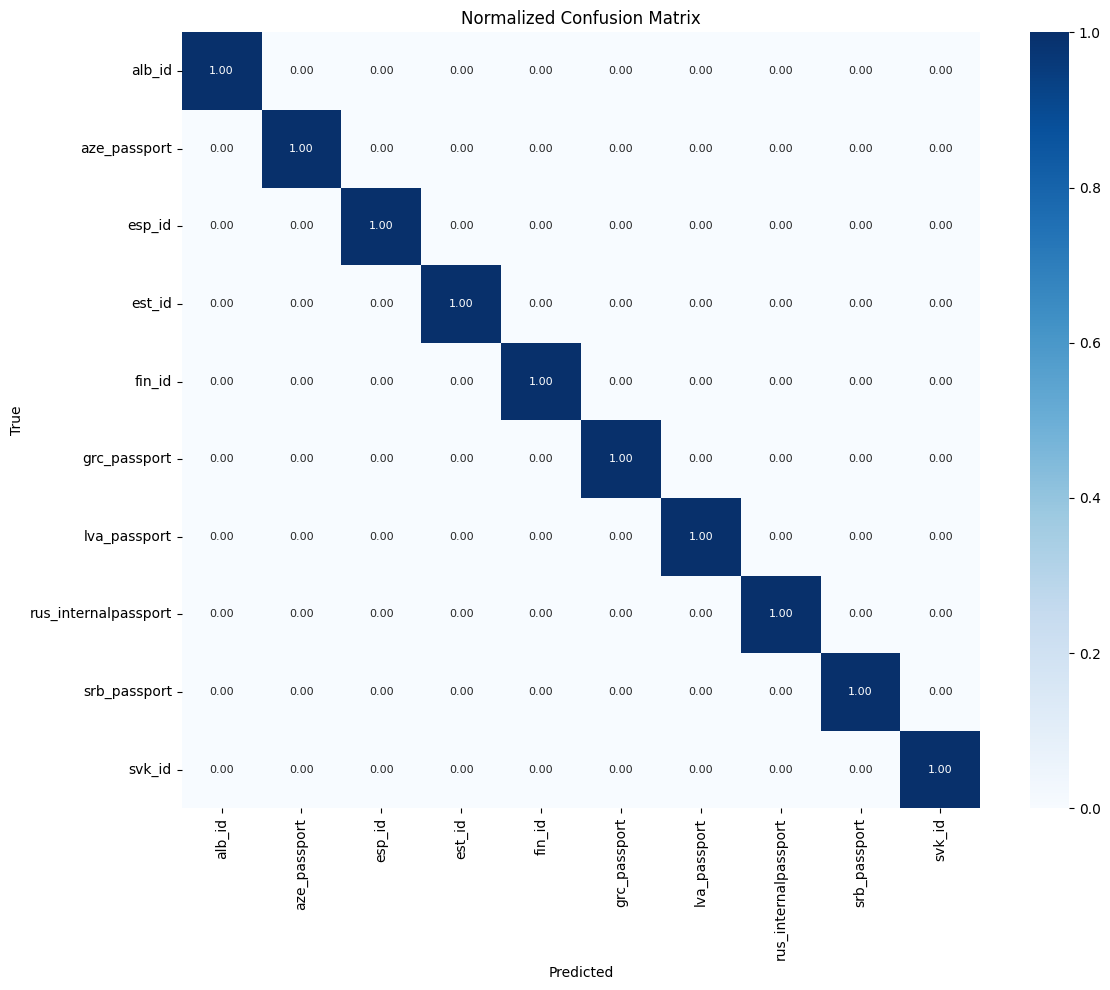

In [12]:
# Evaluate the model on the test set
test_metrics = evaluate_model(model, data['test_loader'], device, class_names)

## 10. Analyzing Misclassifications

Let's look at some examples that our model misclassified to understand its weaknesses.

In [13]:
# Visualize misclassified samples
visualize_misclassified_samples(model, data['test_loader'], class_names, device)

No misclassified samples found in the current batch.


## 11. Inference on Single Image

Let's see how we can use our trained model to classify a single image.

True class: srb_passport


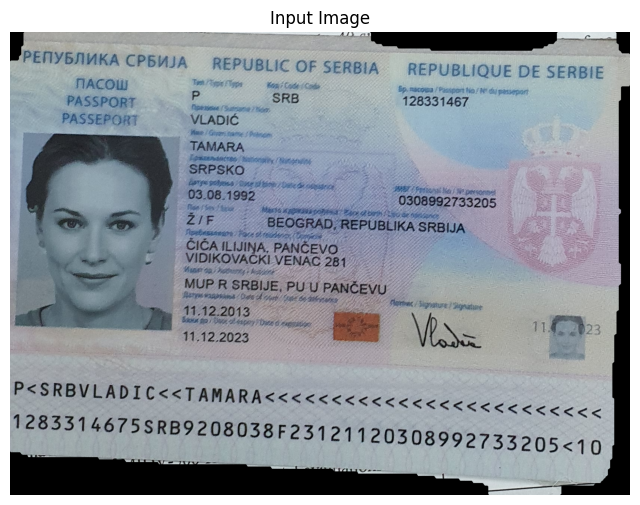

Top 3 predictions:
srb_passport: 99.99%
lva_passport: 0.00%
rus_internalpassport: 0.00%


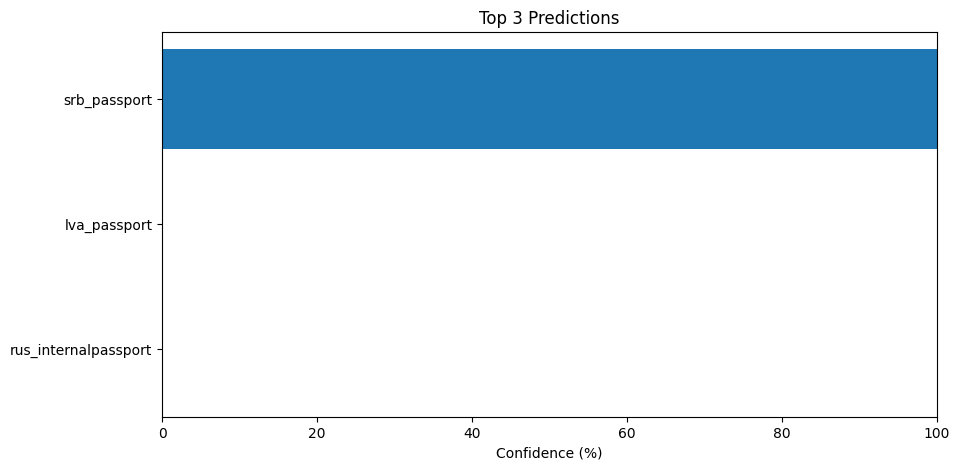

In [14]:
def predict_single_image(model, image_path, transform, class_names, device):
    """
    Predict class for a single image and visualize the result.
    
    Args:
        model: Trained PyTorch model
        image_path: Path to the image file
        transform: Transformation pipeline for inference
        class_names: List of class names
        device: Device to run inference on
    """
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display original image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')
    plt.show()
    
    # Apply transformations
    transformed = transform(image=image)
    image_tensor = transformed['image']
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
    
    # Set model to evaluation mode
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        values, indices = torch.topk(probabilities, 3)  # Get top 3 predictions
    
    # Display prediction results
    values = values.squeeze().cpu().numpy() * 100  # Convert to percentage
    indices = indices.squeeze().cpu().numpy()
    
    print("Top 3 predictions:")
    for i in range(min(3, len(class_names))):
        print(f"{class_names[indices[i]]}: {values[i]:.2f}%")
    
    # Create a horizontal bar chart for visualization
    plt.figure(figsize=(10, 5))
    plt.barh(y=[class_names[idx] for idx in indices[:3]], width=values[:3])
    plt.xlabel('Confidence (%)')
    plt.title('Top 3 Predictions')
    plt.xlim(0, 100)
    plt.gca().invert_yaxis()  # Highest confidence at the top
    plt.show()

# Get a test image for inference
test_dataset = data['test_dataset']
test_idx = np.random.randint(0, len(test_dataset))
test_image_path = test_dataset.image_paths[test_idx]
test_label = test_dataset.labels[test_idx]

# Use validation/test transform for inference (no augmentation)
inference_transform = transforms_dict['test']

# Run inference on the test image
print(f"True class: {class_names[test_label]}")
predict_single_image(model, test_image_path, inference_transform, class_names, device)

## 12. Saving and Loading the Model

Let's see how to save our trained model for later use, and how to load it for inference.

In [17]:
# Define paths
model_name = "custom_cnn_model"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure directory exists
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Save PyTorch `.pth` format (for training & fine-tuning)
save_path_pth = os.path.join(CHECKPOINT_DIR, f"{model_name}_final.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'num_classes': num_classes,
    'img_size': IMG_SIZE,
    'metrics': test_metrics
}, save_path_pth)
print(f"✅ Model saved in .pth format at: {save_path_pth}")

# Save TorchScript `.pt` format (for optimized PyTorch inference)
save_path_pt = os.path.join(CHECKPOINT_DIR, f"{model_name}_scripted.pt")
scripted_model = torch.jit.trace(model, torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device))
torch.jit.save(scripted_model, save_path_pt)
print(f"🚀 Model saved in TorchScript format at: {save_path_pt}")

# Save ONNX `.onnx` format (for deployment & acceleration)
save_path_onnx = os.path.join(CHECKPOINT_DIR, f"{model_name}.onnx")
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)

torch.onnx.export(
    model, 
    dummy_input, 
    save_path_onnx, 
    export_params=True, 
    opset_version=11,  # Ensure compatibility with various runtimes
    do_constant_folding=True, 
    input_names=["input"], 
    output_names=["output"]
)
print(f"Model saved in ONNX format at: {save_path_onnx}")


✅ Model saved in .pth format at: ..\..\checkpoints\custom_cnn\custom_cnn_model_final.pth
🚀 Model saved in TorchScript format at: ..\..\checkpoints\custom_cnn\custom_cnn_model_scripted.pt
Model saved in ONNX format at: ..\..\checkpoints\custom_cnn\custom_cnn_model.onnx


In [15]:
# # Save the model
save_path = os.path.join(CHECKPOINT_DIR, f"{model_name}_final.pth")

# Load the model
def load_model(model_path, device):
    """
    Load a saved model and return it with associated metadata.
    
    Args:
        model_path: Path to the saved model file
        device: Device to load the model on
        
    Returns:
        model: The loaded PyTorch model
        metadata: Dictionary containing model metadata
    """
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Extract metadata
    class_names = checkpoint.get('class_names')
    num_classes = checkpoint.get('num_classes')
    img_size = checkpoint.get('img_size', 224)
    metrics = checkpoint.get('metrics', {})
    
    # Create model
    model = CustomCNNModel(num_classes=num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    return model, {
        'class_names': class_names,
        'num_classes': num_classes,
        'img_size': img_size,
        'metrics': metrics
    }

# Test loading the model
loaded_model, metadata = load_model(save_path, device)
print(f"Model loaded successfully with {metadata['num_classes']} classes: {metadata['class_names']}")
print(f"Test metrics: Accuracy={metadata['metrics'].get('accuracy', 'N/A'):.4f}")

Model saved to ..\..\checkpoints\custom_cnn\custom_cnn_20250320_194805_final.pth


C:\Users\zerad\AppData\Local\Temp\ipykernel_14332\1537654491.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Model loaded successfully with 10 classes: ['alb_id', 'aze_passport', 'esp_id', 'est_id', 'fin_id', 'grc_passport', 'lva_passport', 'rus_internalpassport', 'srb_passport', 'svk_id']
Test metrics: Accuracy=1.0000


## 13. Conclusion

In this notebook, we've walked through the entire process of training a custom CNN model for identity document classification:

1. We set up our environment and loaded our dataset
2. We explored and visualized the dataset, fixing an issue with the visualization function
3. We examined our data augmentation pipeline
4. We created a custom CNN model architecture
5. We trained the model with appropriate hyperparameters
6. We evaluated the model on a test set and analyzed its performance
7. We performed inference on individual images
8. We saved and loaded the model for future use

This model provides a baseline for our identity document classification task. In other notebooks, we'll explore more advanced models using transfer learning.